In [4]:
import numpy as np
import matplotlib.pyplot as plt
final_fig_path = "../CH_Manuscript/Figures/"
import sys
sys.path.insert(1, 'Functions')
from fitness_funs_non_dim import *
from group_w_pop_funs import *
from local_stability_funs import *
from scipy.integrate import solve_ivp
from sim_graph_funs import *
from scipy.optimize import fsolve, minimize, root
import time
colors_x = ['k', 'b', 'r', 'm']

# Groups_no_Pop_Dyn
this notebook plots group dynamics with pop_processes = False in the params dictionary

In [5]:
H=10
x_max = 10
params_base = dict(β1 = 8, β2 = 1, 
                   H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'sigmoid',
                  x_max = x_max, d = 10,A=0.5,
                 Tx = .01, r = 0, γ = 0, pop_process = False)

In [6]:
def full_system_groups(Fvec, N1, N2, params):
    return group_formation_model_non_dim(0,Fvec,N1,N2,params_base)
    
def get_equilibrium_grp(params, N1_0 = 0.5, N2_0 = 0.4, P_0 = 20, F_of_x_vec = None, 
                        iterate_to_initial = False):
    '''
    finds the equilibrium using Fsolve for the population dynamics and group dynamics system
    if not given F_of_x_vec, then just has everyone initially solitary
    
    @returns:
    N1_eq, N2_eq, F_eq, P_eq, mean_x_eq
    '''
    x_max = params['x_max']
    xvec = np.arange(1,x_max+1,1)
    if ~isinstance(F_of_x_vec, np.ndarray):
        x_f = 2 if x_max > 2 else x_max
        F0 = initiate_f_first_x(P_0, x_f, x_max)
        if iterate_to_initial:
            sol = solve_ivp(group_formation_model_non_dim, [0,2], F0, 
                            args = (N1_0,N2_0,params), method = 'LSODA')
            F0 = sol.y[:,-1]
    else:
        F0 = F_of_x_vec
        
    out = root(fun = full_system_groups, x0 = F0, 
                                  args = (N1_0,N2_0,params))

    final_P = np.sum(xvec *out.x)
    no_pop_growth = np.isclose(final_P, P_0, rtol=1e-4) 
    #print(no_pop_growth)
    success = (out.success and no_pop_growth) and np.all(out.x>0)
    return out, success

Function execution time: 12.8437 seconds
Had to iterate 300 times


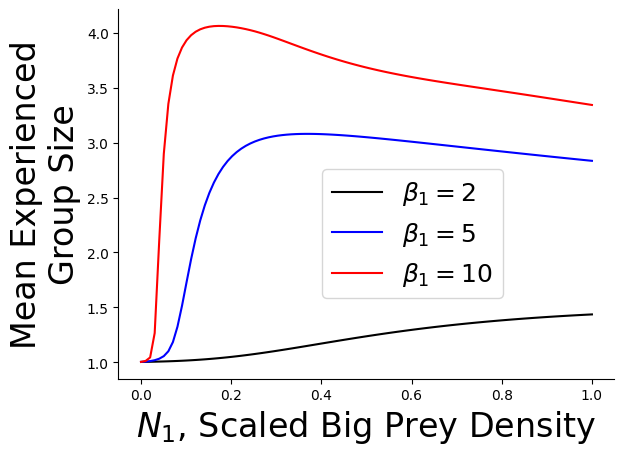

In [9]:
# set up figure
N1lab = r'$N_1$, Scaled Big Prey Density'

def plot_meanx_vs_N1(params):
    fig, ax = plt.subplots(1,1)
    
    N2 = 0.5; P = 20
    N1vec = np.linspace(0,1,100)
    β1vals = [2,5,10]
    F_of_x_vec_initial = np.zeros(params_base['x_max']); F_of_x_vec_initial[0] = P;
    mean_x_vec = np.zeros( len(N1vec) )
    start_time = time.time()
    had_to_iterate = 0
    
    
    for β1_index, β1 in enumerate(β1vals):
        params = params_base.copy()
        params['β1'] = β1
        
        mean_x_vec = np.zeros( len(N1vec) )
        
        for i,N1 in enumerate(N1vec):
            
            out, success = get_equilibrium_grp(params.copy(), N1_0 = N1, N2_0 = N2, 
                                               P_0 = P, F_of_x_vec = None, 
                                          iterate_to_initial = True)
            F_out = out.x
            if success == False:
                had_to_iterate+=1
                sol = solve_ivp(group_formation_model_non_dim, [0, 10], 
                        F_of_x_vec_initial, args=(N1, N2, params.copy()), method='LSODA')
                F_out = sol.y[:,-1]
        
            mean_x_vec[i] = mean_group_size_membership(F_out, params['x_max'], P)
        ax.plot(N1vec, mean_x_vec, color = colors_x[β1_index], label = r'$\beta_1=$'+str(β1))
    
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Function execution time: {elapsed_time:.4f} seconds")
    print(f"Had to iterate {had_to_iterate} times")
    
    
    xlab = N1lab
    ylab = mean_x_lab
    format_ax(ax,xlab,ylab, xlim = None, ylim=None,
                  fs_labs = 24, fs_legend = 18, if_legend = True,
                 ncol_legend = 1)
    
    return fig, ax
fig, ax = plot_meanx_vs_N1(params_base.copy())  
ax.legend(loc='best', bbox_to_anchor=(0.3, 0.1, 0.5, 0.5), fontsize = 18)
fig.savefig(final_fig_path+'mean_x_vs_N1_no_pop.png', bbox_inches = 'tight', dpi = 600)

Function execution time: 13.6590 seconds
Had to iterate 300 times


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$N_1$, Scaled Big Prey\nDensity', ylabel='Mean Group Size\n Membership'>)

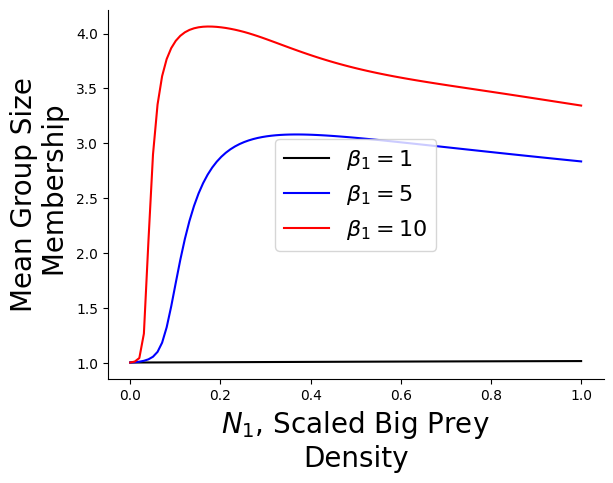

In [14]:
params = params_base.copy()
params['d'] = 5
plot_meanx_vs_N1(params)

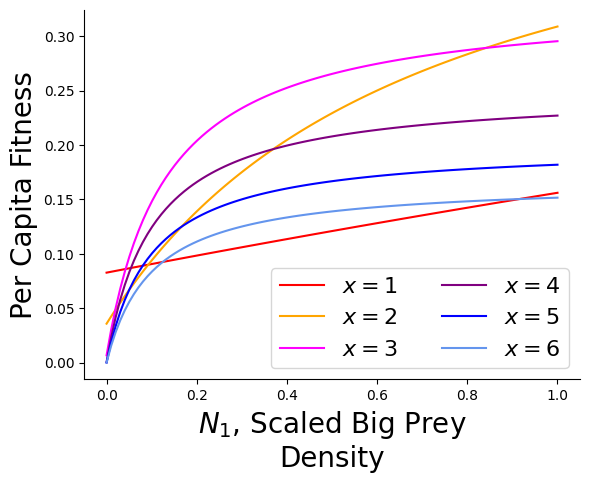

In [26]:
fig, ax = plt.subplots(1,1)
N2=0.5; P=1
N1vec = np.linspace(0,1,100)


# \beta_1 = 1
params = params_base.copy()
params['β1'] = 10
for x in range(1,7):
    fitnessx = [per_capita_fitness_from_prey_non_dim(x, N1, N2, **params) for N1 in N1vec]
    ax.plot(N1vec, fitnessx,color = colors[x-1], label = r'$x=$'+str(x))
xlab = N1lab
ylab = 'Per Capita Fitness'
format_ax(ax,xlab,ylab, xlim = None, ylim=None,
              fs_labs = 20, fs_legend = 16, if_legend = True,
             ncol_legend = 2)

fig.savefig(final_fig_path+'fitness_vs_N1_no_pop.png', bbox_inches = 'tight', dpi = 600)

Function execution time: 0.0063 seconds
Had to iterate 0 times


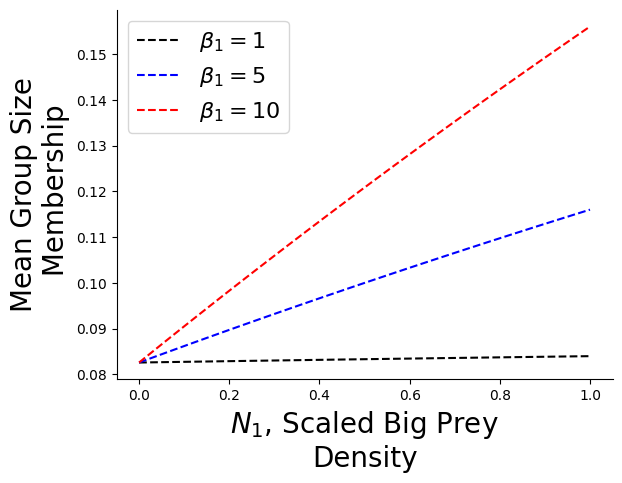

In [10]:
# set up figure
fig, ax = plt.subplots(1,1)

N2 = 0.5; P = 1
N1vec = np.linspace(0,1,100)
β1vals = [1,5,10]
F_of_x_vec_initial = np.zeros(params_base['x_max']); F_of_x_vec_initial[0] = P;
mean_x_vec = np.zeros( len(N1vec) )
start_time = time.time()
had_to_iterate = 0


for β1_index, β1 in enumerate(β1vals):
    params = params_base.copy()
    params['β1'] = β1
    
    mean_x_vec = np.zeros( len(N1vec) )
    
    fitness1 = [per_capita_fitness_from_prey_non_dim(1, N1, N2, **params) for N1 in N1vec]
    
    
    ax.plot(N1vec, fitness1, '--',color = colors_x[β1_index], label = r'$\beta_1=$'+str(β1))
    #out = get_equilibrium_grp(params, N1_0 = N1, N2_0 = N2, P_0 = P, F_of_x_vec = None)
    #F_out = out.x
    #if np.any(F_out<0) or out.success == False: # or also if 
    #    mean_x_vec[i] = np.nan
    #else:
    #    mean_x_vec[i] = mean_group_size_membership(F_out, params['x_max'], P)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Function execution time: {elapsed_time:.4f} seconds")
print(f"Had to iterate {had_to_iterate} times")


xlab = N1lab
ylab = mean_x_lab
format_ax(ax,xlab,ylab, xlim = None, ylim=None,
              fs_labs = 20, fs_legend = 16, if_legend = True,
             ncol_legend = 1)
#fig.savefig(final_fig_path+'mean_x_vs_N1_no_pop.png', bbox_inches = 'tight')

In [86]:
N1=1; N2 = 0.5; P = 1
N1vec = np.linspace(0,1,100)
F_of_x_vec_initial = np.zeros(params_base['x_max']); F_of_x_vec_initial[0] = P;
group_formation_model_non_dim(0,F_of_x_vec_initial,N1,N2, params_base.copy())

array([-199.39522334,   99.69761167,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ])

In [84]:
np.sum(F_out*xvec)

np.float64(0.9999999999999999)

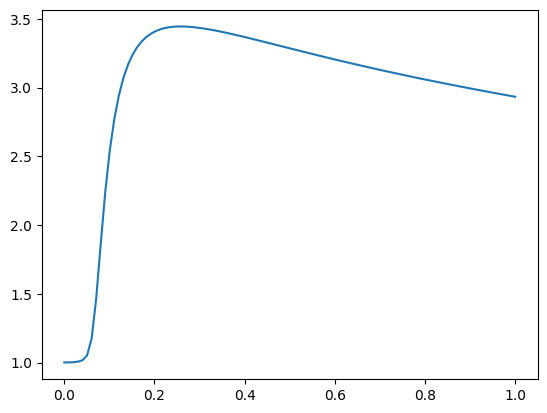

In [146]:
plt.plot(N1vec,mean_x_vec)

In [26]:
N1 = 0.5; N2 = 0.5; P = 1
F_of_x_vec_initial = np.zeros(params_base['x_max']); F_of_x_vec_initial[0] = P;
sol = solve_ivp(group_formation_model_non_dim, [0, 10], 
                F_of_x_vec_initial, args=(N1, N2, params_base), method='RK45')

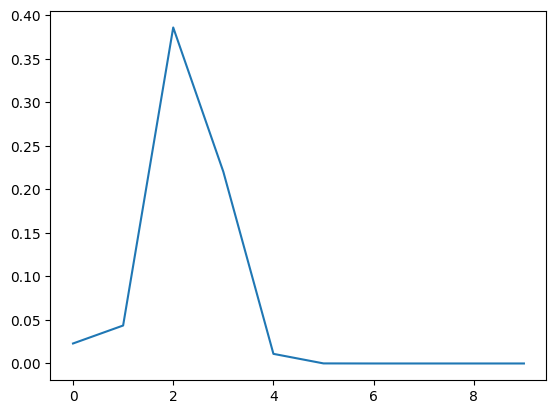

In [32]:
out = get_equilibrium_grp(params_base.copy(), N1_0 = 0.5, N2_0 = 0.4, P_0 = 3, F_of_x_vec = None)
plt.plot(out.x)

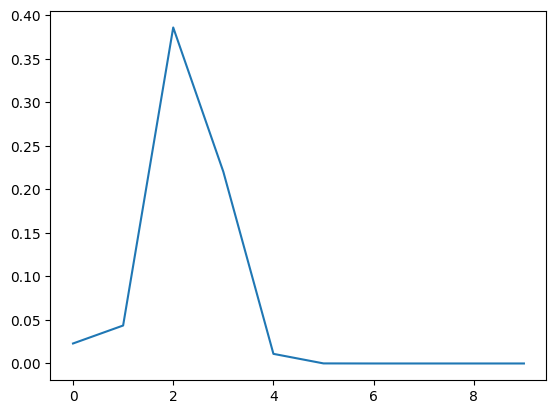

In [34]:
out = get_equilibrium_grp(params_base.copy(), N1_0 = 0.5, N2_0 = 0.4, P_0 = 3, F_of_x_vec = F_of_x_vec_initial)
plt.plot(out.x)

In [23]:
T = sol.t
F_out = sol.y
mean_x = mean_group_size_membership(F_out.T, x_max, P)

In [12]:
T

array([0.00000000e+00, 1.00503957e-05, 1.10554353e-04, ...,
       9.99639746e+00, 9.99946679e+00, 1.00000000e+01])

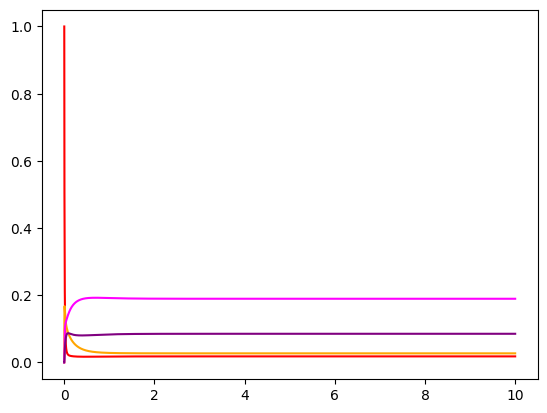

In [27]:
i = 0
for F in F_out:
    if np.max(F)>0.05:
        plt.plot(T,F, c = colors[i])
        i+=1